# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [74]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.model_selection import ParameterGrid
import time


In [2]:
import warnings
warnings.filterwarnings("ignore")

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [27]:
# Define a function to load data and aggregate them
def read_stock_data_from_files_combine(file_names, dir_path,drop_columns=None):
    combined_df = pd.DataFrame()

    for file in file_names:
        # Extract stock name (before the first underscore)
        stock_name = file.split('_')[0]

        # Construct full path and read CSV
        file_path = os.path.join(dir_path, file)
        df = pd.read_csv(file_path)

        # Drop unnecessary columns if specified
        if drop_columns:
            df.drop(columns=[col for col in drop_columns if col in df.columns], inplace=True)

         # rename columns (except 'Date') with the stock name prefix
        df = df.rename(columns={
            col: f"{stock_name}_{col}" for col in df.columns if col != 'Date'
        })

          # Convert Date column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # set 'Date' as the index for joining dataframes
        df = df.set_index('Date')

        # Append to combined DataFrame
        combined_df = pd.concat([combined_df, df],axis= 1)

          # sort by date index
        combined_df = combined_df.sort_index()

    return combined_df


In [29]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_names = [
    'AMZN_stocks_data.csv',
    'GOOGL_stocks_data.csv',
    'IBM_stocks_data.csv',
    'MSFT_stocks_data.csv'
]
dir_path = 'RNN_Stocks_Data'
drop_cols = ['Name']
all_stocks_df = read_stock_data_from_files_combine(file_names,dir_path, drop_cols)

In [30]:
all_stocks_df.head()


AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
Date                                                                  
2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

            GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  GOOGL_Volume  \
Date                                                                       
2006-01-03      211.47      218.05     209.32       217.83    13137450.0   
2006-01-04      222.17      224.70     220.09       222.84    15292353.0   
2006-01-05      223.22      226.00     220.97       225.85    10815661.0   
2006-01-06      228.66      235.49     226.85       233.06    17759521.0   
2006-01-09      233.44      236.94     230.70       233.68    12795837.0   

            IBM_Open  IBM_High  IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  \
Date                                                                        
2006-01-03     82.45     82.55    80.81      82.06    11715200      26.25   
2006-01-04     82.20     82.50    81.33      81.95     9840600      26.77   
2006-01-05     81.40     82.90    81.00      82.50     7213500      26.96   
2006-01-06     83.95     85.03    83.41      84.95     8197400      26.89   
2006-01-09     84.10     84.25    83.38      83.73     6858200      26.93   

            MSFT_High  MSFT_Low  MSFT_Close  MSFT_Volume  
Date                                                      
2006-01-03      27.00     26.10       26.84   79974418.0  
2006-01-04      27.08     26.77       26.97   57975661.0  
2006-01-05      27.13     26.91       26.99   48247610.0  
2006-01-06      27.00     26.49       26.91  100969092.0  
2006-01-09      27.07     26.76       26.86   55627836.0

In [31]:
# View specifics of the data
all_stocks_df.tail()


AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
Date                                                                  
2017-12-22    1172.08    1174.62   1167.83     1168.36    1585054.0   
2017-12-26    1168.36    1178.32   1160.55     1176.76    2005187.0   
2017-12-27    1179.91    1187.29   1175.61     1182.26    1867208.0   
2017-12-28    1189.00    1190.10   1184.38     1186.10    1841676.0   
2017-12-29    1182.35    1184.00   1167.50     1169.47    2688391.0   

            GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  GOOGL_Volume  \
Date                                                                       
2017-12-22     1070.00     1071.72    1067.64      1068.86      889446.0   
2017-12-26     1068.64     1068.86    1058.64      1065.85      918767.0   
2017-12-27     1066.60     1068.27    1058.38      1060.20     1116203.0   
2017-12-28     1062.25     1064.84    1053.38      1055.95      994249.0   
2017-12-29     1055.49     1058.05    1052.70      1053.40     1180340.0   

            IBM_Open  IBM_High  IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  \
Date                                                                        
2017-12-22    151.82    153.00   151.50     152.50     2990583      85.40   
2017-12-26    152.51    153.86   152.50     152.83     2479017      85.31   
2017-12-27    152.95    153.18   152.61     153.13     2149257      85.65   
2017-12-28    153.20    154.12   153.20     154.04     2687624      85.90   
2017-12-29    154.17    154.72   153.42     153.42     3327087      85.63   

            MSFT_High  MSFT_Low  MSFT_Close  MSFT_Volume  
Date                                                      
2017-12-22      85.63     84.92       85.51   14145841.0  
2017-12-26      85.53     85.03       85.40    9891237.0  
2017-12-27      85.98     85.22       85.71   14678025.0  
2017-12-28      85.93     85.55       85.72   10594344.0  
2017-12-29      86.05     85.50       85.54   18717406.0

In [32]:
all_stocks_df.shape

(3020, 20)

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [33]:
# Handle Missing Values
all_stocks_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AMZN_Open     3019 non-null   float64
 1   AMZN_High     3019 non-null   float64
 2   AMZN_Low      3019 non-null   float64
 3   AMZN_Close    3019 non-null   float64
 4   AMZN_Volume   3019 non-null   float64
 5   GOOGL_Open    3019 non-null   float64
 6   GOOGL_High    3019 non-null   float64
 7   GOOGL_Low     3019 non-null   float64
 8   GOOGL_Close   3019 non-null   float64
 9   GOOGL_Volume  3019 non-null   float64
 10  IBM_Open      3019 non-null   float64
 11  IBM_High      3020 non-null   float64
 12  IBM_Low       3019 non-null   float64
 13  IBM_Close     3020 non-null   float64
 14  IBM_Volume    3020 non-null   int64  
 15  MSFT_Open     3019 non-null   float64
 16  MSFT_High     3019 non-null   float64
 17  MSFT_Low      3019 non-null   float64
 18  MSFT_Close

In [34]:
#print missing values per column
print('missing values percolumn')
print(all_stocks_df.isnull().sum())

missing values percolumn
AMZN_Open       1
AMZN_High       1
AMZN_Low        1
AMZN_Close      1
AMZN_Volume     1
GOOGL_Open      1
GOOGL_High      1
GOOGL_Low       1
GOOGL_Close     1
GOOGL_Volume    1
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       1
MSFT_High       1
MSFT_Low        1
MSFT_Close      1
MSFT_Volume     1
dtype: int64


In [ ]:
# Handle missing values
#imputemissing values using forward fill method
all_stocks_df.ffill(inplace=True)

In [36]:
# Check again
print("check Missing values after filling:")
print(all_stocks_df.isnull().sum())

check Missing values after filling:
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        0
IBM_High        0
IBM_Low         0
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

<Figure size 1200x600 with 0 Axes>

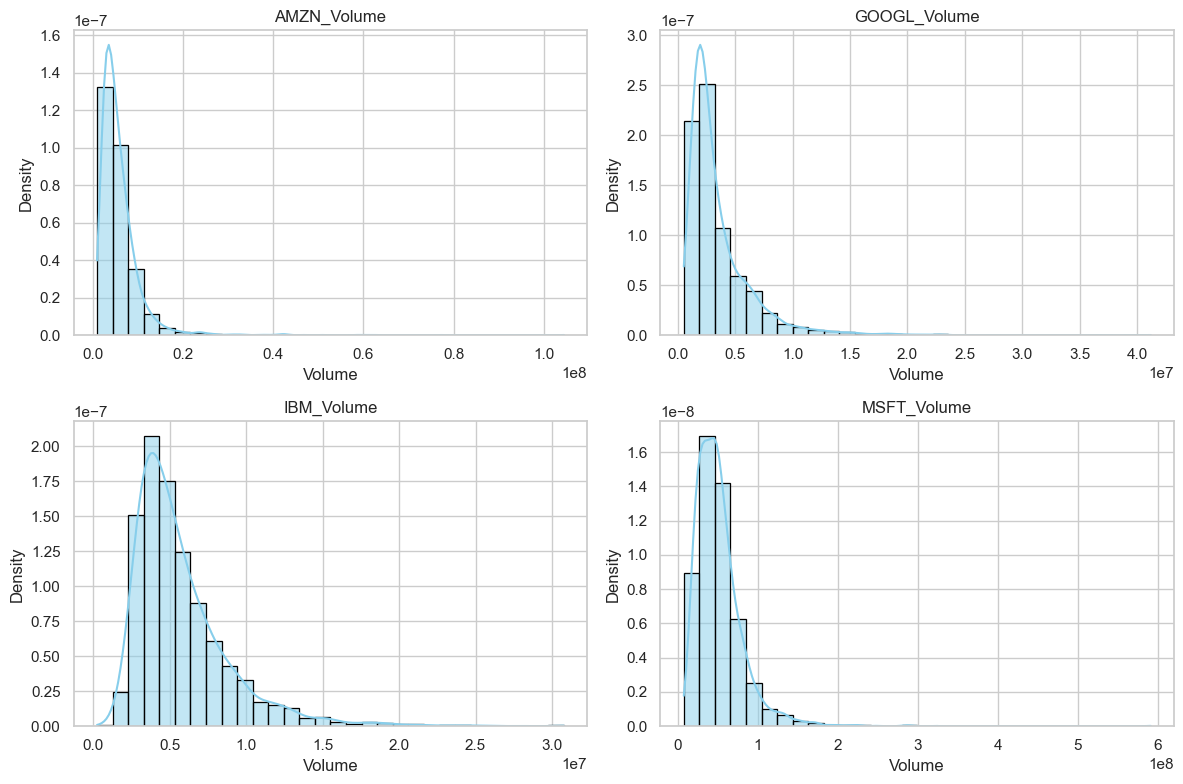

In [ ]:
# Frequency distribution of volumes

volume_columns = [col for col in all_stocks_df.columns if 'Volume' in col]
plt.figure(figsize=(12, 6))

# Set up 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  # Flatten to simplify indexing

# Plot each volume distribution
for i, col in enumerate(volume_columns):
    sns.histplot(all_stocks_df[col], kde=True, bins=30, ax=axes[i], color='skyblue', edgecolor='black', stat='density')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Volume')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)

# Hide unused axes if any (optional safety)
for j in range(len(volume_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

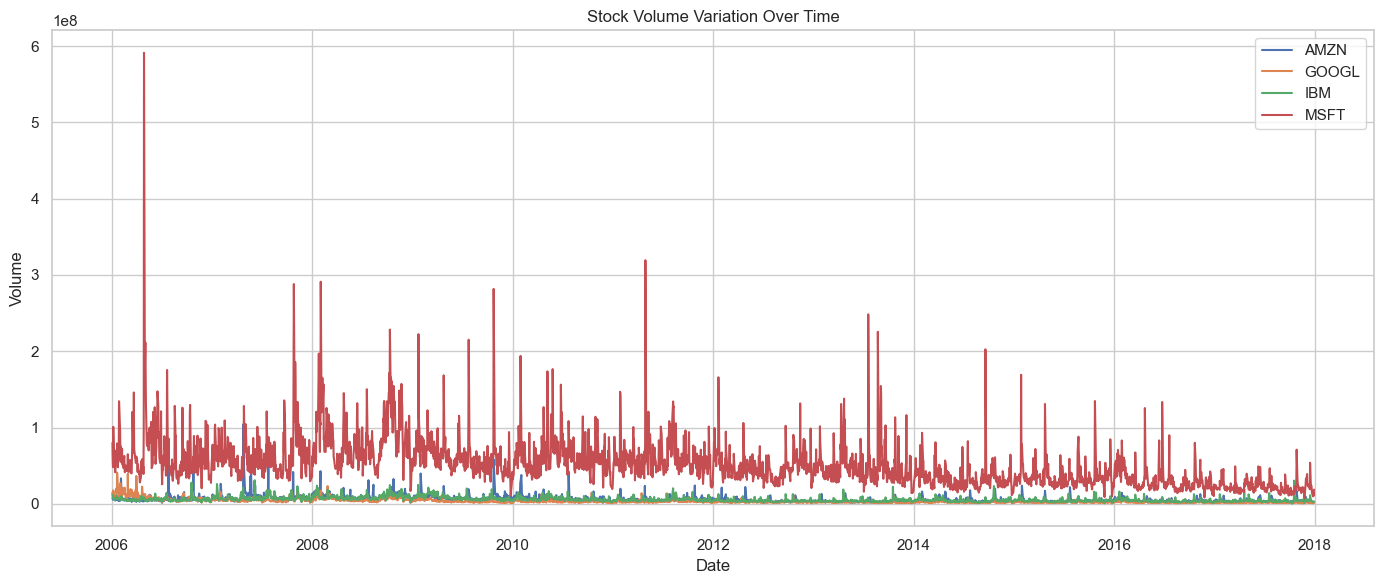

In [46]:
# Stock volume variation over time

plt.figure(figsize=(14, 6))

# Plot each volume column
for col in volume_columns:
    stock_name = col.replace('_Volume', '')
    plt.plot(all_stocks_df.index, all_stocks_df[col], label=stock_name)

# Plot formatting
plt.title('Stock Volume Variation Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Observations**
- The Microsoft stock volume, shown in red, consistently exhibits the highest values and notable spikes compared to the others.

- Amazon’s stock volume, represented in blue, is lower than Microsoft’s but remains significantly above IBM and Google.

- IBM’s trading volume, marked in green, is generally among the lowest of the four stocks.

- Google’s stock volume, displayed in orange, also ranks low, similar to IBM, showing comparatively smaller fluctuations.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

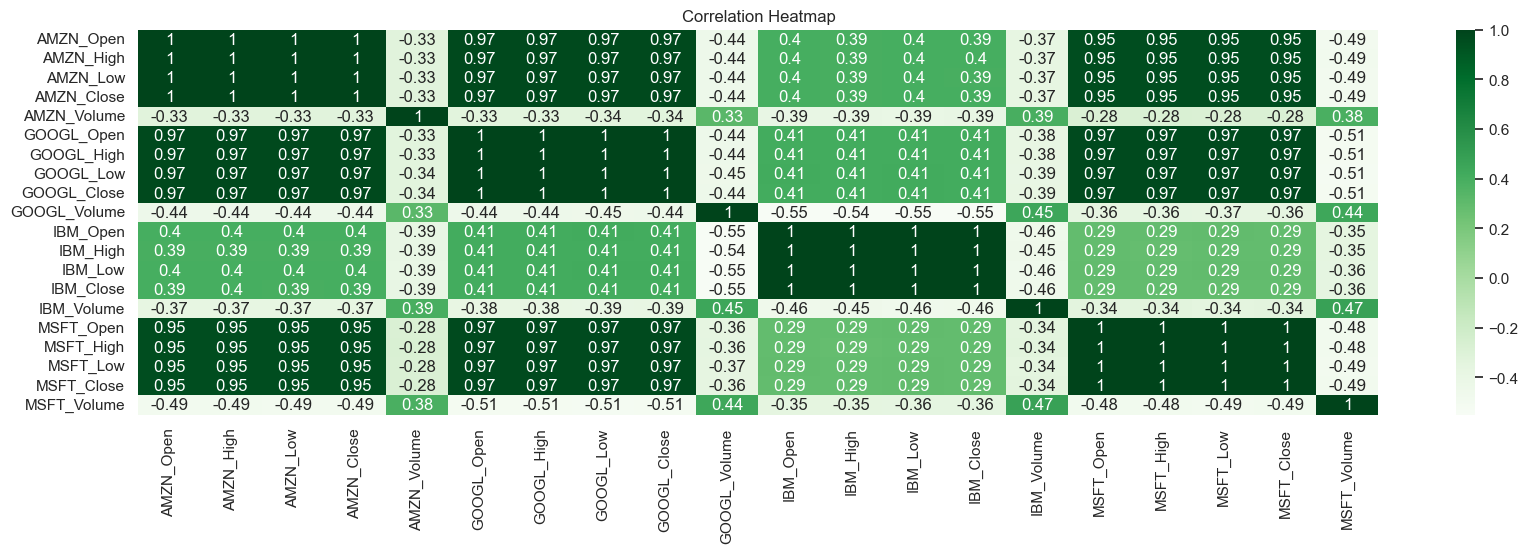

In [48]:
# Analyse correlations
# Analyse correlations
plt.figure(figsize=(20, 5)) 

# heatmap
sns.heatmap(all_stocks_df.corr(), annot=True, cmap='Greens')
plt.title('Correlation Heatmap')
plt.show()


**Observation**
- The correlation analysis reveals a strong relationship among the price features (open, close, high, low) of Microsoft, Amazon, and Google stocks.

- In contrast, IBM's stock prices show weak correlation with those of the other three, especially with Microsoft.

- This suggests that Microsoft, Amazon, and Google share similar stock price trends, which are likely higher and more aligned than those of IBM.

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [65]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_window_data(df, window_size, step_size, target_cols):
    X, y = [], []

    # Ensure DataFrame is sorted by date
    df = df.sort_index()

    # Total number of rows
    total_rows = df.shape[0]

    for start in range(0, total_rows - window_size, step_size):
        end = start + window_size
        window = df.iloc[start:end]

        # Target is the 'Close' price(s) at the next time step (right after window)
        target_row = df.iloc[end]  # future time step

        # Collect Close prices for selected stocks from target_row
        targets = [target_row[f"{stock}"] for stock in target_cols]

        X.append(window)
        y.append(targets)

    return np.array(X), np.array(y)  

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [64]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):
    X_scaled = []
    y_scaled = []

    # Initialize scalers
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    # Iterate over each window and target
    for i in range(len(X)):
        x_window = X[i]
        y_value = y[i]

        # Fit and transform features window
        X_scaler.partial_fit(x_window)
        scaled_x_window = X_scaler.transform(x_window)

        # Fit and transform target
        y_reshaped = y_value.reshape(1, -1)
        y_scaler.partial_fit(y_reshaped)
        scaled_y = y_scaler.transform(y_reshaped)[0]

        # Append to results
        X_scaled.append(scaled_x_window)
        y_scaled.append(scaled_y)

    return np.array(X_scaled), np.array(y_scaled)



Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [66]:
# Define a function to create input and output data points from the master DataFrame

# Define a function to create input and output data points from the master DataFrame

def prepare_data_for_rnn(df, target_cols, window_size, window_stride, split_ratio):
    # Create windowed X and y
    X, y = create_window_data(df, window_size, window_stride, target_cols)
    
    # Scale windowed X and y
    X_scaled, y_scaled = scale_windowed_data(X, y)

    # Perform train-test split
    split_index = int(len(X_scaled) * split_ratio)

    # For input features (X): take the first part for training, and the rest for testing
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    
    # For target values (y): take the first part for training, and the rest for testing
    y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

    return X_train, y_train, X_test, y_test

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

Analyzing patterns for: AMZN_Close


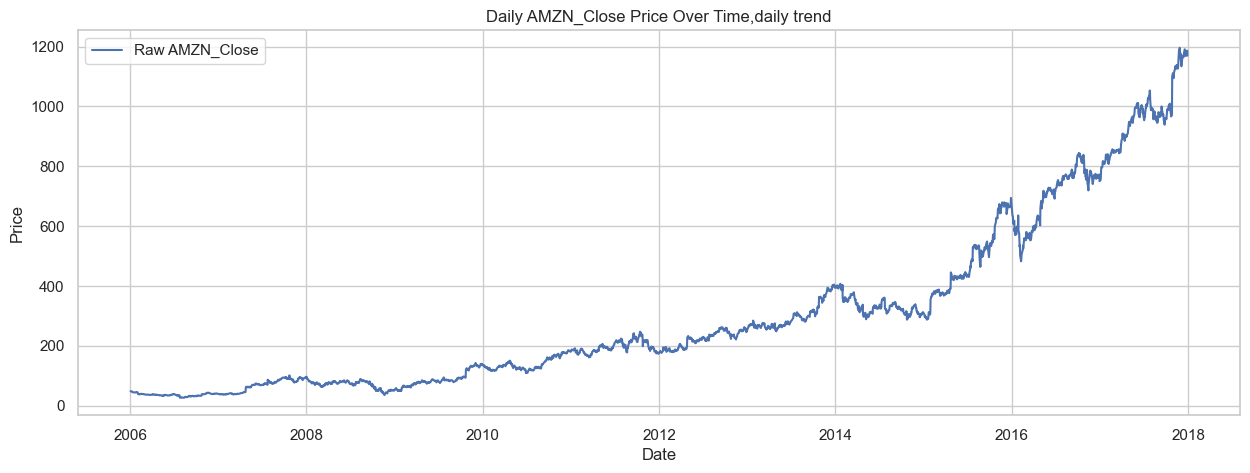

In [53]:
# Checking for patterns in different sequence lengths

# look at AMZN price
target_col_analyz = 'AMZN_Close'
print(f"Analyzing patterns for: {target_col_analyz}")

# 1. Visual Inspection of Raw Data
plt.figure(figsize=(15, 5))
plt.plot(all_stocks_df.index, all_stocks_df[target_col_analyz], label=f'Raw {target_col_analyz}')
plt.title(f'Daily {target_col_analyz} Price Over Time,daily trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


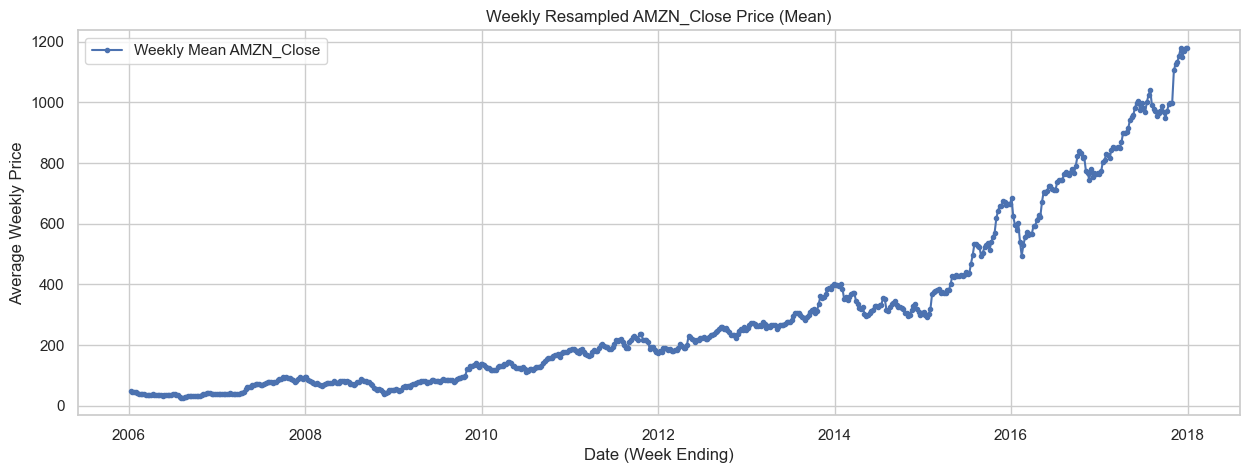

In [54]:
# Resample to Weekly frequency (taking the mean price for each week)
# 'W' stands for weekly frequency, ending on Sunday by default.
weekly_data = all_stocks_df[target_col_analyz].resample('W').mean()
plt.figure(figsize=(15, 5))
plt.plot(weekly_data.index, weekly_data, label=f'Weekly Mean {target_col_analyz}', marker='.', linestyle='-')
plt.title(f'Weekly Resampled {target_col_analyz} Price (Mean)')
plt.xlabel('Date (Week Ending)')
plt.ylabel('Average Weekly Price')
plt.legend()
plt.grid(True)
plt.show()

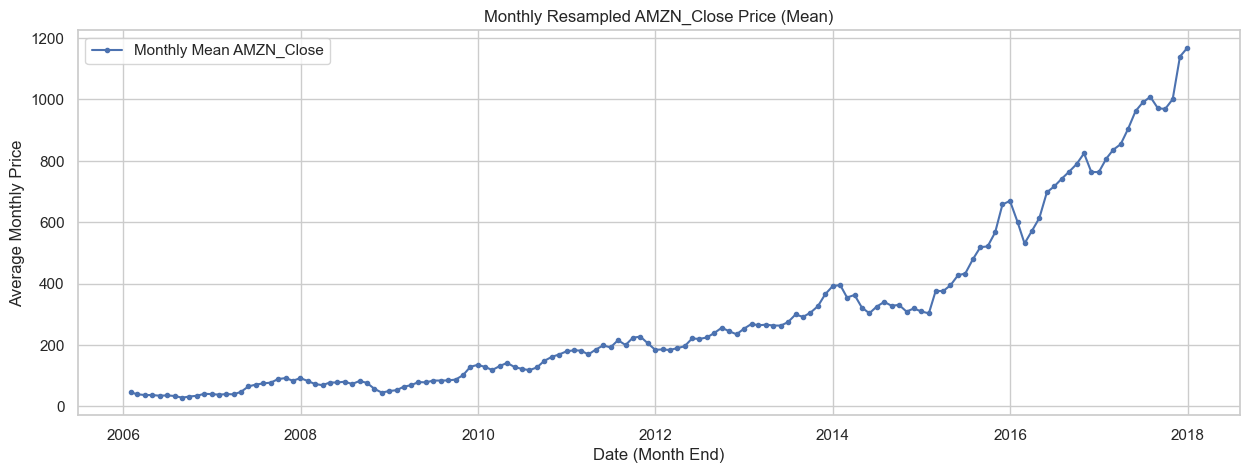

In [55]:
# Resample to Monthly frequency (taking the mean price for each month end)
# 'ME' stands for Month End frequency.
monthly_data = all_stocks_df[target_col_analyz].resample('ME').mean()
plt.figure(figsize=(15, 5))
plt.plot(monthly_data.index, monthly_data, label=f'Monthly Mean {target_col_analyz}', marker='.', linestyle='-')
plt.title(f'Monthly Resampled {target_col_analyz} Price (Mean)')
plt.xlabel('Date (Month End)')
plt.ylabel('Average Monthly Price')
plt.legend()
plt.grid(True)
plt.show()

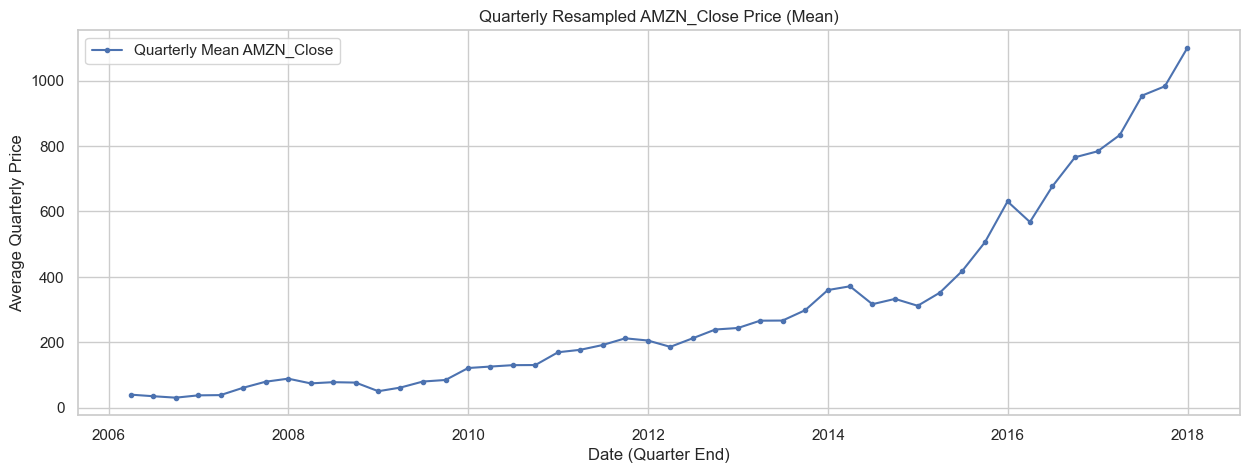

In [56]:
# 'QE' stands for Quarter End frequency.
quarterly_data = all_stocks_df[target_col_analyz].resample('QE').mean()
plt.figure(figsize=(15, 5))
plt.plot(quarterly_data.index, quarterly_data, label=f'Quarterly Mean {target_col_analyz}', marker='.', linestyle='-')
plt.title(f'Quarterly Resampled {target_col_analyz} Price (Mean)')
plt.xlabel('Date (Quarter End)')
plt.ylabel('Average Quarterly Price')
plt.legend()
plt.grid(True)
plt.show()

**Observation**
Since the weekly, monthly, and quarterly plots of the stock’s closing prices show similar overall trends, this indicates:

- There is no strong seasonality or cyclic pattern tied to shorter or longer time periods.

  The stock movements are primarily driven by a consistent trend rather than by specific time intervals.

Given this, selecting a moderate window size—around 20 business days, roughly equivalent to one month—is appropriate because it:

- Captures sufficient historical information

- Avoids being so long that it risks overfitting or masking recent developments

This choice aligns well with the observed monthly trend in the data.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [67]:
# Create data instances from the master data frame using decided window size and window stride
# Parameters
window_size = 20
step_size = 1
split_ratio = 0.8

# Let's move ahead with AMAZON Closing stock price for first model
target_cols = ['AMZN_Close']

# Create data
X_train, y_train, X_test, y_test = prepare_data_for_rnn(all_stocks_df, target_cols, window_size, step_size, split_ratio)
print(f"Shape of X_train:{X_train.shape}, y_train:{y_train.shape}, X_test:{X_test.shape}, y_test:{y_test.shape}")

Shape of X_train:(2400, 20, 20), y_train:(2400, 1), X_test:(600, 20, 20), y_test:(600, 1)


In [ ]:
# Check the number of data points generated


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks

#X_train should be 3D arrays of shape:
print(f"X_train shape: {X_train.shape}")

# y_train Should be 2D arrays of shape:
print(f"y_train shape: {y_train.shape}")

X_train shape: (2400, 20, 20)
y_train shape: (2400, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [72]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_rnn_model_simple(no_units, activation, input_shape, dropout_rate, target_len):
    # Initialize the model
    model = Sequential()
    
    # Add the Simple RNN layer
    model.add(SimpleRNN(units=no_units, activation=activation, input_shape=input_shape, return_sequences=False))
    
    # Add dropout for regularization
    model.add(Dropout(dropout_rate))
   
    # Add a Dense output layer , default to linear activation as this is regression problem
    model.add(Dense(target_len))
    
    # Compile the model with Adam optimizer and MSE loss function 
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [77]:

# Define the hyperparameter grid
param_grid = {
    'units': [16, 32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4],
    'activation': ['tanh', 'relu'],
    'batch_size': [16, 32],
    'epochs': [30]  # fixed across all runs
}

# Create combinations
hyperparameter_combinations = list(ParameterGrid(param_grid))
print(f"Total combinations to evaluate: {len(hyperparameter_combinations)}")

# Input/output shapes
input_shape = X_train.shape[1:]
target_len = 1  # or y_train.shape[1] if multidimensional

results = []

# Grid search loop
for idx, params in enumerate(hyperparameter_combinations):
    print(f"\n--- Running combination {idx + 1}/{len(hyperparameter_combinations)} ---")
    print(f"Config: {params}")
    
    # Build model
    model = build_rnn_model_simple(
        no_units=params['units'],
        activation=params['activation'],
        input_shape=input_shape,
        dropout_rate=params['dropout_rate'],
        target_len=target_len
    )
    
    # Track training time
    start = time.time()
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )
    
    duration = time.time() - start

    # Evaluate
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

    # Save results
    results.append({
        'params': params,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'training_time': duration,
        'history': history.history
    })

    print(f"Result → MSE: {test_loss:.4f} | MAE: {test_mae:.4f} | Time: {duration:.2f}s")

    # Clear memory
    #tf.keras.backend.clear_session()

    
   



Total combinations to evaluate: 64

--- Running combination 1/64 ---
Config: {'activation': 'tanh', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 30, 'units': 16}
Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3384 - mae: 0.4225 - val_loss: 0.0093 - val_mae: 0.0788
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0506 - mae: 0.1732 - val_loss: 0.0078 - val_mae: 0.0727
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0323 - mae: 0.1404 - val_loss: 0.0198 - val_mae: 0.1246
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238 - mae: 0.1219 - val_loss: 0.0050 - val_mae: 0.0586
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - mae: 0.1062 - val_loss: 0.0041 - val_mae: 0.0534
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0980 - val_loss: 0.0049 - val_mae: 0.0569
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - mae: 0.0900 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 8/

In [80]:
  # Clear memory
import tensorflow as tf
tf.keras.backend.clear_session()

In [88]:
# Find the best configuration based on evaluation metrics
import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame([
    {
        'units': r['params']['units'],
        'activation': r['params']['activation'],
        'dropout_rate': r['params']['dropout_rate'],
        'batch_size': r['params']['batch_size'],
        'test_loss': r['test_loss'],
        'test_mae': r['test_mae'],
        'training_time': r['training_time']
    }
    for r in results
])

# Sort by test loss (lower is better)
results_df_sorted = results_df.sort_values('test_loss')
print("🔝 Top 5 models based on test loss:")
print(results_df_sorted.head(5))

# Get best configuration
best_params = results_df_sorted.iloc[0].to_dict()

print("\n Best Model Configuration:")
for param, value in best_params.items():
    if param not in ['test_loss', 'test_mae', 'training_time']:
        print(f"{param}: {value}")

print("\n Best Model Metrics:")
print(f"Test Loss (MSE): {best_params['test_loss']:.6f}")
print(f"Test MAE: {best_params['test_mae']:.6f}")
print(f"Training Time: {best_params['training_time']:.2f} seconds")



🔝 Top 5 models based on test loss:
    units activation  dropout_rate  batch_size  test_loss  test_mae  \
3     128       tanh           0.1          16   0.000344  0.013196   
30     64       tanh           0.4          32   0.000351  0.013435   
6      64       tanh           0.2          16   0.000385  0.014323   
9      32       tanh           0.3          16   0.000433  0.015618   
1      32       tanh           0.1          16   0.000443  0.016572   

    training_time  
3       10.385436  
30       7.495133  
6       10.940005  
9        9.706973  
1        9.674394  

 Best Model Configuration:
units: 128
activation: tanh
dropout_rate: 0.1
batch_size: 16

 Best Model Metrics:
Test Loss (MSE): 0.000344
Test MAE: 0.013196
Training Time: 10.39 seconds


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

Training final model with optimal hyperparameters:
units: 128
dropout_rate: 0.1
activation: tanh
batch_size: 16
epochs: 50
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0910 - mae: 0.2225 - val_loss: 0.0021 - val_mae: 0.0371 - learning_rate: 0.0010
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - mae: 0.0941 - val_loss: 0.0017 - val_mae: 0.0331 - learning_rate: 0.0010
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - mae: 0.0800 - val_loss: 0.0093 - val_mae: 0.0875 - learning_rate: 0.0010
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - mae: 0.0687 - val_loss: 0.0013 - val_mae: 0.0280 - learning_rate: 0.0010
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0608 - val_loss: 0.0037 - val_mae: 0.0519 - learning_rate: 0.0010
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - mae: 0.0543 - val_loss: 9.9514e-04 - val_mae: 0.0257 - learning_rate: 0.0010
Epoch 7/50
120/120 ━━

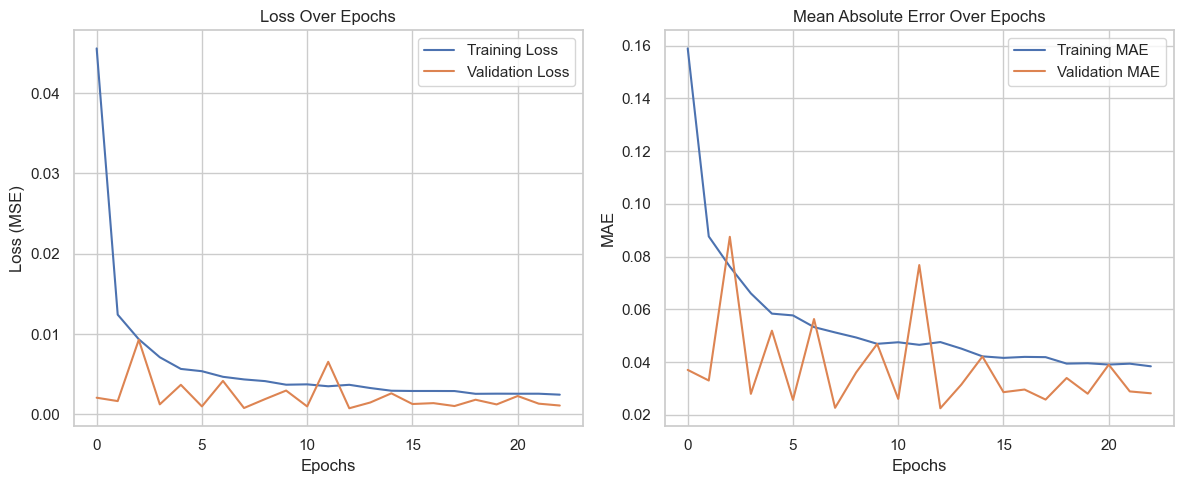

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Make sure activation is set, otherwise default to 'tanh'
activation = best_params.get('activation', 'tanh')

# Set hyperparameters for final training
optimal_params = {
    'units': int(best_params['units']),
    'dropout_rate': best_params['dropout_rate'],
    'activation': activation,
    'batch_size': int(best_params['batch_size']),
    'epochs': 50
}

print("Training final model with optimal hyperparameters:")
for param, value in optimal_params.items():
    print(f"{param}: {value}")

# Input and output shape
time_steps, n_features = X_train.shape[1], X_train.shape[2]
target_len = y_train.shape[1] if len(y_train.shape) > 1 else 1

# Clear previous TF session
tf.keras.backend.clear_session()

# Build model with the best params (ignoring learning_rate for now)
final_simple_rnn_model = build_rnn_model_simple(
    no_units=optimal_params['units'],
    activation=optimal_params['activation'],
    input_shape=(time_steps, n_features),
    dropout_rate=optimal_params['dropout_rate'],
    target_len=target_len
)

# Optional: If you want to apply learning rate tuning, define optimizer explicitly
# optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
# final_simple_rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for early stopping and LR reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4
    )
]

# Train the model
final_history = final_simple_rnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=optimal_params['epochs'],
    batch_size=optimal_params['batch_size'],
    callbacks=callbacks,
    verbose=1
)

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['mae'], label='Training MAE')
plt.plot(final_history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Shape of y_test: (600, 1)
Shape of y_pred: (600, 1)


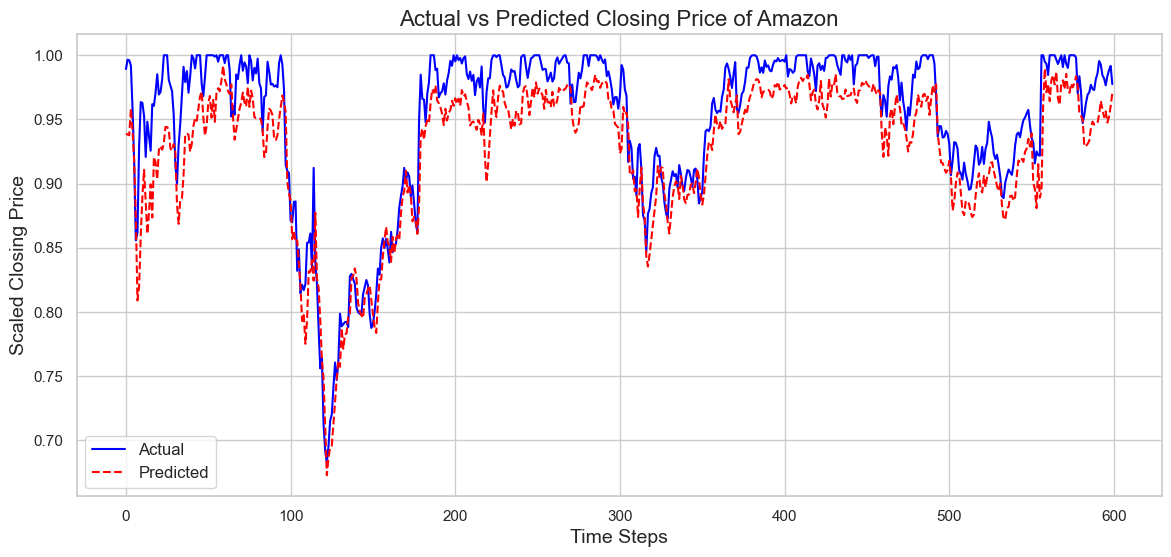

In [89]:
# Predict on the test data and plot

# Predict on test data
y_pred = final_simple_rnn_model.predict(X_test)

print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Plot Actual vs Predicted
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Price of Amazon', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Scaled Closing Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [90]:
# Compute the performance of the model on the testing data set

from sklearn.metrics import mean_squared_error

# Evaluate on the test data
test_loss, test_mae = final_simple_rnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Compute performance metrices
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print out the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0302  
Test Loss: 0.0009079861920326948
Test MAE: 0.025537190958857536
Mean Absolute Error (MAE): 0.02553719365283671
Mean Squared Error (MSE): 0.0009079863009330361
Root Mean Squared Error (RMSE): 0.030132811036029085
R-squared (R²): 0.759665844617196


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [95]:
# Define a function to create a model and specify default values for hyperparameters
def build_rnn_lstm_model(input_shape, output_shape, lstm_units=64, dense_units=32, 
                       lstm_layers=1, dropout_rate=0.2, learning_rate=0.001):
   
    # input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    # add LSTM layers
    for i in range(lstm_layers):
        return_sequences = i < lstm_layers - 1  # Only the last layer should return sequences=False
        x = tf.keras.layers.LSTM(units=lstm_units, 
                                activation='tanh',
                                return_sequences=return_sequences)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # dense layer
    x = tf.keras.layers.Dense(units=dense_units, activation='relu')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(output_shape, activation='linear')(x)
    
    # create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # compile model with Adam optimizer and MSE loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [93]:
from sklearn.model_selection import ParameterGrid
import time

# Hyperparameter grid with ~64 combinations
lstm_param_grid = {
    'lstm_units': [64, 80, 96, 128],    # 4 options
    'dense_units': [32, 64],            # 2 options
    'lstm_layers': [1, 2],              # 2 options
    'dropout_rate': [0.2, 0.3],         # 2 options
    'learning_rate': [0.001, 0.005],    # 2 options
    'batch_size': [32],                 # 1 option to control total count
    'epochs': [30]                     # fixed epochs
}

lstm_hyperparameter_combinations = list(ParameterGrid(lstm_param_grid))
print(f"Total number of combinations: {len(lstm_hyperparameter_combinations)}")  # Should print 64

# Initialize results list
lstm_results = []

time_steps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = y_train.shape[1] if len(y_train.shape) > 1 else 1

for i, params in enumerate(lstm_hyperparameter_combinations):
    print(f"\nTraining LSTM model {i+1}/{len(lstm_hyperparameter_combinations)}")
    print(f"Parameters: {params}")

    model = build_rnn_lstm_model(
        input_shape=(time_steps, n_features),
        output_shape=n_outputs,
        lstm_units=params['lstm_units'],
        dense_units=params['dense_units'],
        lstm_layers=params['lstm_layers'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )

    training_time = time.time() - start_time

    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

    lstm_results.append({
        'params': params,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'training_time': training_time,
        'history': history.history
    })

    print(f"Test loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Training time: {training_time:.2f}s")

    tf.keras.backend.clear_session()


Total number of combinations: 64

Training LSTM model 1/64
Parameters: {'batch_size': 32, 'dense_units': 32, 'dropout_rate': 0.2, 'epochs': 30, 'learning_rate': 0.001, 'lstm_layers': 1, 'lstm_units': 64}
Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3023 - mean_absolute_error: 0.4034 - val_loss: 0.0044 - val_mean_absolute_error: 0.0564
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - mean_absolute_error: 0.0965 - val_loss: 0.0020 - val_mean_absolute_error: 0.0368
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - mean_absolute_error: 0.0798 - val_loss: 0.0024 - val_mean_absolute_error: 0.0419
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - mean_absolute_error: 0.0730 - val_loss: 0.0021 - val_mean_absolute_error: 0.0374
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - mean_absolute_error: 0.0686 - val_loss: 0.0031 - val_mean_absolute_error: 0.0467
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

In [94]:
#find the best configurarion

import pandas as pd

# Convert LSTM tuning results to DataFrame for easier analysis
lstm_results_df = pd.DataFrame([
    {
        'lstm_units': r['params']['lstm_units'],
        'dense_units': r['params']['dense_units'],
        'lstm_layers': r['params']['lstm_layers'],
        'dropout_rate': r['params']['dropout_rate'],
        'learning_rate': r['params']['learning_rate'],
        'batch_size': r['params']['batch_size'],
        'test_loss': r['test_loss'],
        'test_mae': r['test_mae'],
        'training_time': r['training_time']
    } for r in lstm_results
])

# Sort results by test loss (lower is better)
lstm_results_df_sorted = lstm_results_df.sort_values('test_loss')

print("Top 5 LSTM model configurations by test loss:")
print(lstm_results_df_sorted.head(5))

# Extract best configuration
lstm_best_params = lstm_results_df_sorted.iloc[0].to_dict()

print("\nBest LSTM model hyperparameters:")
for param, value in lstm_best_params.items():
    if param not in ['test_loss', 'test_mae', 'training_time']:
        print(f"{param}: {value}")

print(f"\nBest LSTM model performance metrics:")
print(f"Test Loss (MSE): {lstm_best_params['test_loss']:.6f}")
print(f"Test MAE: {lstm_best_params['test_mae']:.6f}")
print(f"Training Time: {lstm_best_params['training_time']:.2f} seconds")


Top 5 LSTM model configurations by test loss:
    lstm_units  dense_units  lstm_layers  dropout_rate  learning_rate  \
27         128           32            1           0.3          0.005   
18          96           32            1           0.3          0.001   
2           96           32            1           0.2          0.001   
12          64           32            2           0.2          0.005   
8           64           32            1           0.2          0.005   

    batch_size  test_loss  test_mae  training_time  
27          32   0.000573  0.015734      12.270131  
18          32   0.000676  0.021250      10.718708  
2           32   0.000986  0.022686      10.597188  
12          32   0.001005  0.018346      14.226987  
8           32   0.001036  0.026093       8.776193  

Best LSTM model hyperparameters:
lstm_units: 128.0
dense_units: 32.0
lstm_layers: 1.0
dropout_rate: 0.3
learning_rate: 0.005
batch_size: 32.0

Best LSTM model performance metrics:
Test Loss (MSE):

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

Starting final LSTM training with the following hyperparameters:
lstm_units: 128
dense_units: 32
lstm_layers: 1
dropout_rate: 0.3
learning_rate: 0.005
batch_size: 32
epochs: 50
Resetting Keras backend and clearing memory...
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2470 - mean_absolute_error: 0.3140 - val_loss: 0.0080 - val_mean_absolute_error: 0.0753 - learning_rate: 0.0050
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0763 - val_loss: 0.0032 - val_mean_absolute_error: 0.0468 - learning_rate: 0.0050
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0660 - val_loss: 0.0036 - val_mean_absolute_error: 0.0498 - learning_rate: 0.0050
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - mean_absolute_error: 0.0653 - val_loss: 0.0022 - val_mean_absolute_error: 0.0401 - learning_rate: 0.0050
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mean_absolute_error: 

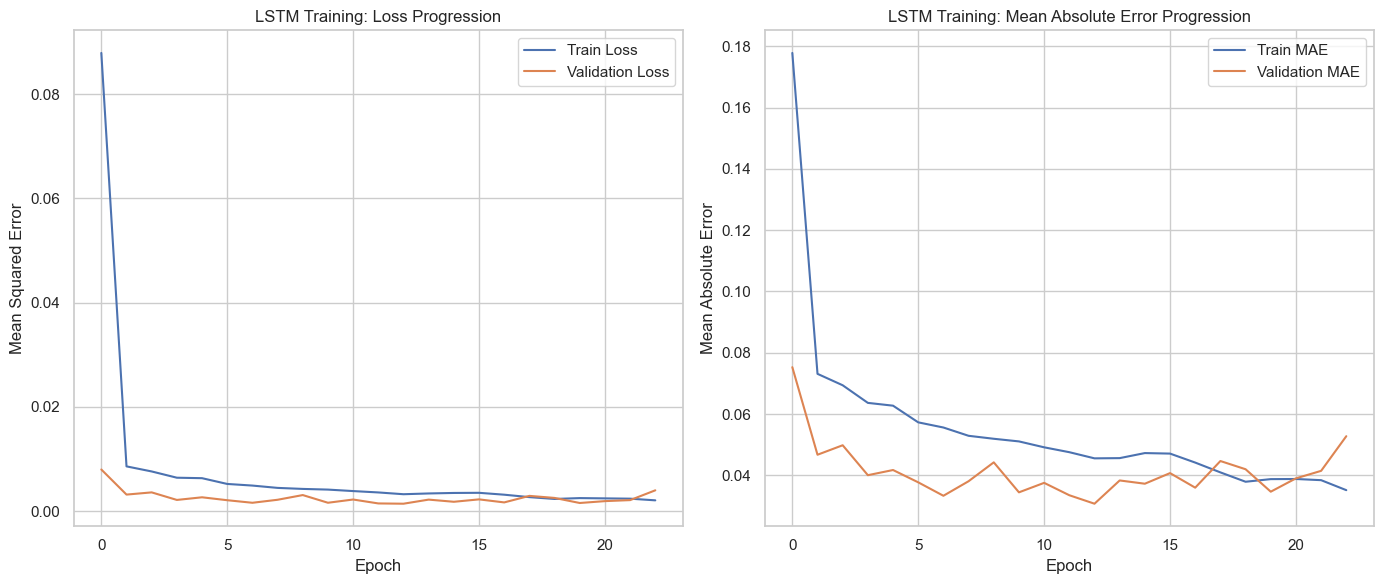

In [96]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
# Set the best hyperparameters from tuning results for final LSTM training
final_lstm_params = {
    'lstm_units': int(lstm_best_params['lstm_units']),
    'dense_units': int(lstm_best_params['dense_units']),
    'lstm_layers': int(lstm_best_params['lstm_layers']),
    'dropout_rate': lstm_best_params['dropout_rate'],
    'learning_rate': lstm_best_params['learning_rate'],
    'batch_size': int(lstm_best_params['batch_size']),
    'epochs': 50  # Increase epochs for final training
}

print("Starting final LSTM training with the following hyperparameters:")
for key, val in final_lstm_params.items():
    print(f"{key}: {val}")

print("Resetting Keras backend and clearing memory...")
tf.keras.backend.clear_session()
import gc
gc.collect()

# Construct the LSTM model with optimal hyperparameters
final_lstm_model = build_rnn_lstm_model(
    input_shape=(time_steps, n_features),
    output_shape=n_outputs,
    lstm_units=final_lstm_params['lstm_units'],
    dense_units=final_lstm_params['dense_units'],
    lstm_layers=final_lstm_params['lstm_layers'],
    dropout_rate=final_lstm_params['dropout_rate'],
    learning_rate=final_lstm_params['learning_rate']
)

# Configure callbacks for early stopping and adaptive learning rate
training_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4
    )
]

# Fit the model on the training data with validation split
final_training_history = final_lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=final_lstm_params['epochs'],
    batch_size=final_lstm_params['batch_size'],
    callbacks=training_callbacks,
    verbose=1
)

# Visualize training and validation metrics over epochs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(final_training_history.history['loss'], label='Train Loss')
plt.plot(final_training_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training: Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_training_history.history['mean_absolute_error'], label='Train MAE')
plt.plot(final_training_history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('LSTM Training: Mean Absolute Error Progression')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shape of y_test: (600, 1)
Shape of y_pred: (600, 1)


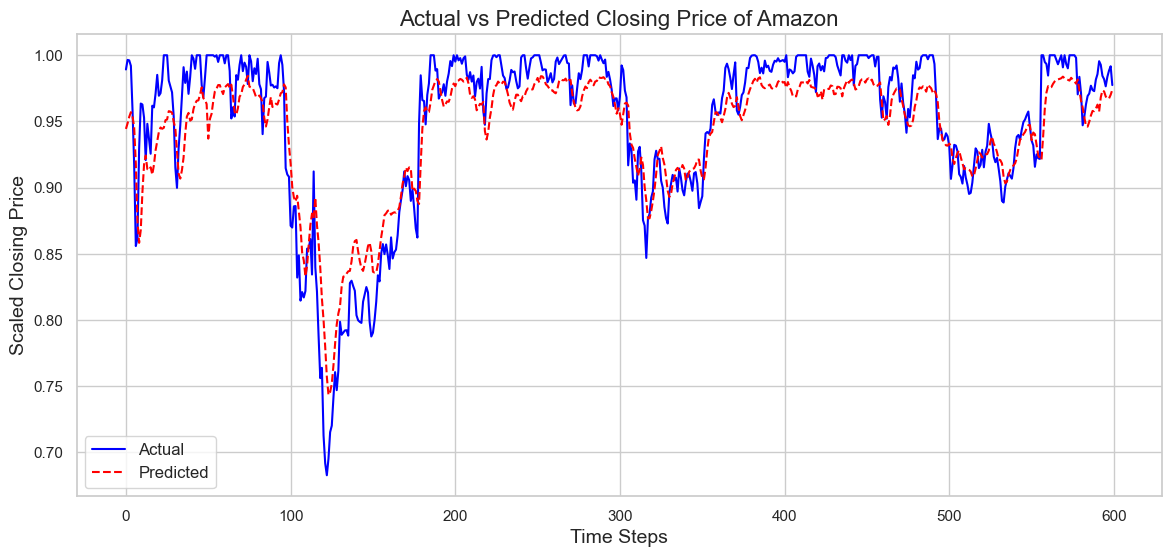

In [98]:
# Compute the performance of the model on the testing data set

# Predict on test data
y_pred = final_lstm_model.predict(X_test)

print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Plot Actual vs Predicted
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Price of Amazon', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Scaled Closing Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()



Plotting the actual vs predicted values

In [99]:
# Predict on the test data
from sklearn.metrics import mean_squared_error

# Evaluate on the test data
test_loss, test_mae = final_lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Compute performance metrices
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print out the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7265e-04 - mean_absolute_error: 0.0255
Test Loss: 0.0006319720996543765
Test MAE: 0.020141476765275
Mean Absolute Error (MAE): 0.020141475689007288
Mean Squared Error (MSE): 0.0006319720614676106
Root Mean Squared Error (RMSE): 0.025139054506238108
R-squared (R²): 0.8327238291345662


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

In this project, we designed and assessed various recurrent neural network models, concentrating on Simple RNN and LSTM architectures, to forecast stock closing prices. The process involved comprehensive data preprocessing, including windowing and scaling, as well as model construction. We then carried out detailed hyperparameter optimization to find the most effective model settings.

### EDA Observations

- Microsoft’s stock volume consistently exhibits the highest values with notable spikes compared to the other stocks.

- Amazon’s trading volume is lower than Microsoft’s but remains significantly higher than both IBM and Google.

- IBM’s trading volume generally ranks among the lowest of the four stocks.

- Google’s trading volume is similarly low to IBM’s, showing relatively smaller fluctuations.

### Simple RNN model

Best accuracy is achieved through this model configuration
 Best Model Configuration:
units: 128
activation: tanh
dropout_rate: 0.1
batch_size: 16

accuracy metrics: 

Test Loss: 0.0009079861920326948
Test MAE: 0.025537190958857536
Mean Absolute Error (MAE): 0.02553719365283671
Mean Squared Error (MSE): 0.0009079863009330361
Root Mean Squared Error (RMSE): 0.030132811036029085
R-squared (R²): 0.759665844617196

### Advanced RNN Models using LSTM

Best accuracy is achieved through this model configuration
Best LSTM model hyperparameters:
lstm_units: 128.0
dense_units: 32.0
lstm_layers: 1.0
dropout_rate: 0.3
learning_rate: 0.005
batch_size: 32.0

accuracy metrics: 

Test Loss: 0.0006319720996543765
Test MAE: 0.020141476765275
Mean Absolute Error (MAE): 0.020141475689007288
Mean Squared Error (MSE): 0.0006319720614676106
Root Mean Squared Error (RMSE): 0.025139054506238108
R-squared (R²): 0.8327238291345662

### conclusion 
- LSTM modelisgiven the best results for validation

### Conclusion

In this project, two recurrent neural network architectures were developed and evaluated for time series forecasting of stock prices: a Simple RNN and an advanced LSTM model.

**Simple RNN Model:**  
The best configuration for the Simple RNN included 128 units with a tanh activation, dropout rate of 0.1, and batch size of 16. It achieved solid performance metrics, showing decent predictive ability.

**Advanced LSTM Model:**  
The LSTM model outperformed the Simple RNN with optimal hyperparameters: 128 LSTM units, 32 dense units, 1 LSTM layer, dropout rate of 0.3, learning rate of 0.005, and batch size of 32. It demonstrated stronger predictive power and better generalization.

Overall, the **LSTM model delivered the best validation results** and is the preferred architecture for forecasting stock prices due to its superior ability to capture temporal dependencies.

| Metric                | Simple RNN Model      | LSTM Model            |
|-----------------------|----------------------|----------------------|
| Test Loss (MSE)       | 0.00091              | 0.00063              |
| Mean Absolute Error   | 0.0255               | 0.0201               |
| Root Mean Squared Error| 0.0301              | 0.0251               |
| R-squared (R²)        | 0.76                 | 0.83                 |
